# Pitch Onset Features

In the following we always assume a sample rate of 22050.

Imports:

In [1]:
import librosa
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import time
from IPython import display

%matplotlib inline

For being compareable with Matlab we need a special peak picking function...

In [2]:
def peaks(W, direction, abs_thresh):
    rel_thresh = 0.5 * np.repeat(np.sqrt(np.var(W)), len(W))
    descent_thresh = 0.5 * rel_thresh
    tmin, tmax = 0, len(W)
    
    dyold = 0
    dy = 0
    rise = 0               # current amount of ascent during a rising portion of the signal W
    riseold = 0            # accumulated amount of ascent from the last rising portion of W
    descent = 0            # current amount of descent (<0) during a falling portion of the signal W
    searching_peak = True
    candidate = 0
    P = []
    
    if direction == 1:
        this_range = np.arange(tmin, tmax-2)
    elif direction == -1:
        this_range = np.arange(tmax, tmin, -1)
        
    for i in this_range:
        dy = W[i+direction] - W[i]
        if dy >= 0:
            rise = rise + dy
        else:
            descent = descent + dy
            
        if dyold >= 0:
            if dy < 0: # slope change positive->negative
                if (rise >= rel_thresh[i]) and searching_peak:
                    candidate = i
                    searching_peak = False
                riseold = rise
                rise = 0
        # dyold < 0
        else:
            if dy < 0: # in descent
                if (descent <= -rel_thresh[candidate]) and not searching_peak:
                    if (W[candidate] >= abs_thresh[candidate]):
                        P.append(candidate)     # verified candidate as true peak
                    searching_peak = True
            else: # dy >= 0 slope change negative->positive
                if not searching_peak: # currently verifying a peak
                    if W[candidate] - W[i] <= descent_thresh[i]:
                        rise = riseold + descent # skip intermediary peak
                    if descent <= -rel_thresh[candidate]:
                        if W[candidate] >= abs_thresh[candidate]:
                            P.append(candidate)     # verified candidate as true peak
                    searching_peak = True
                descent = 0
        dyold = dy
        
    return np.array(P)

Compute filter coefficients the same way as in `stft_log_frequency_pitch_filterbank.ipynb`:

In [3]:
midi_min, midi_max = 20, 107 # midi range to be considered

midi_pitches = np.arange(midi_min, midi_max+1)
center_freqs = librosa.core.midi_to_hz(midi_pitches)

fs_pitch = np.zeros(128) # sample rates per midi putch
fs_pitch[20:59] = 882
fs_pitch[59:95] = 4410
fs_pitch[95:120] = 22050

midi_pitches = np.arange(128) # midi pitches and center frequencies
center_freqs = librosa.core.midi_to_hz(midi_pitches)

# filter specifications
passband_ripple = 1 # in dB
stopband_attenuation = 50 # in dB
Q = 25
nyquist = fs_pitch / 2
filter_bandwidths = center_freqs / Q

pitch_filterbank = dict()

for p, cur_center_freq, cur_sr, cur_nyquist, cur_bw in zip(midi_pitches[midi_min:midi_max+1], center_freqs[midi_min:midi_max+1], fs_pitch[midi_min:midi_max+1], nyquist[midi_min:midi_max+1], filter_bandwidths):
    passband_freqs = [cur_center_freq - cur_bw / 2, cur_center_freq + cur_bw / 2] / cur_nyquist
    stopband_freqs = [cur_center_freq - cur_bw, cur_center_freq + cur_bw] / cur_nyquist

    cur_filter = scipy.signal.iirdesign(passband_freqs, stopband_freqs,
                                        passband_ripple, stopband_attenuation,
                                        analog=False, ftype='ellip', output='ba')
    pitch_filterbank[p] = cur_filter

Some parameters:

In [4]:
fs_index = np.zeros(128, dtype='int') # index per midi pitch
fs_index[20:59] = 2
fs_index[59:95] = 1
fs_index[95:120] = 0

window_size     = np.array([101, 41, 21])
down_step       = np.array([50, 10, 10])
samples_per_sec = np.array([22050, 4410, 882]) / down_step
cut_off         = np.array([1/down_step[0], 1/down_step[1], 0.05])
res_fac         = np.array([50, 50, 250])
win_lengths     = np.array([100, 100, 50]) # window lengths for local maximum in peak picking for fs=22050, fs=4410, fs=882

f_peaks = dict() # the final onset features

Load Audio and resample into three bands:

In [5]:
y, fs = librosa.load('../data/Systematic_Scale-C-Major_Meinard_fast.wav')
pcm_ds = dict()
pcm_ds[0] = y
pcm_ds[1] = scipy.signal.decimate(pcm_ds[0], 5, zero_phase=True)
pcm_ds[2] = scipy.signal.decimate(pcm_ds[1], 5, zero_phase=True)

Loop over pitches and compute f_peaks;

In [6]:
f_peaks_num = 0

for p in range(midi_min, midi_max+1):
    index = fs_index[p]
    b, a = pitch_filterbank[p]
    f_filtfilt = scipy.signal.filtfilt(b, a, pcm_ds[index])
    ws = window_size[index]
    ds = down_step[index]
    
    # local energy curve
    f_square = f_filtfilt ** 2
    window = np.hanning(ws)
    f_energy = scipy.signal.upfirdn(window,f_square,1,ds)
    delay = int(np.floor((ws-1)/(ds*2)))
    energy_len = int(np.floor(len(f_filtfilt)/ds))
    f_energy = f_energy[delay:delay+energy_len]
    
    # further smoothing of energy curve
    if (cut_off[index] < 0.01) or (cut_off[index] > 0.98):
        raise RuntimeError('cut off frequency too small or too large')
    Wp = cut_off[index]
    n, Wn = scipy.signal.cheb2ord(Wp, Wp+0.01, 1, 20)
    b, a = scipy.signal.cheby2(n, 20, Wn)
    f_energy = scipy.signal.filtfilt(b, a, f_energy)
    
    # discrete differentation and halfwave rectifying
    f_onset = np.diff(f_energy)
    f_onset = f_onset * (f_onset>0)
    
    # compute f_peaks using a local threshold method
    # normalization of samples with respect to fs = 22050
    f_len = len(f_onset);
    win_len = win_lengths[index]
    sample_first = 0
    thresh = np.zeros(f_len)
    while sample_first < f_len:
        sample_last = min(sample_first + win_len - 1, f_len - 1)
        win_max = np.max(f_onset[sample_first:sample_last])
        thr = 2 * win_max / 3
        thresh[sample_first:sample_last+1] = np.repeat(thr, sample_last - sample_first + 1)
        sample_first = sample_first + win_len
        
    res = res_fac[index]
    res_center = int(np.ceil(res / 2))
    
    this_peaks = peaks(f_onset, 1, thresh)
    this_onsets = f_onset[this_peaks] if len(this_peaks) != 0 else np.array([])
    this_peaks = this_peaks * res - res_center
    this_peaks = this_peaks * 1000 / 22050 # convert to time in ms

    f_peaks[p] = (this_peaks, this_onsets) # (onset time, onset value)
    f_peaks_num += len(this_peaks)

Visualize pitch onset features.

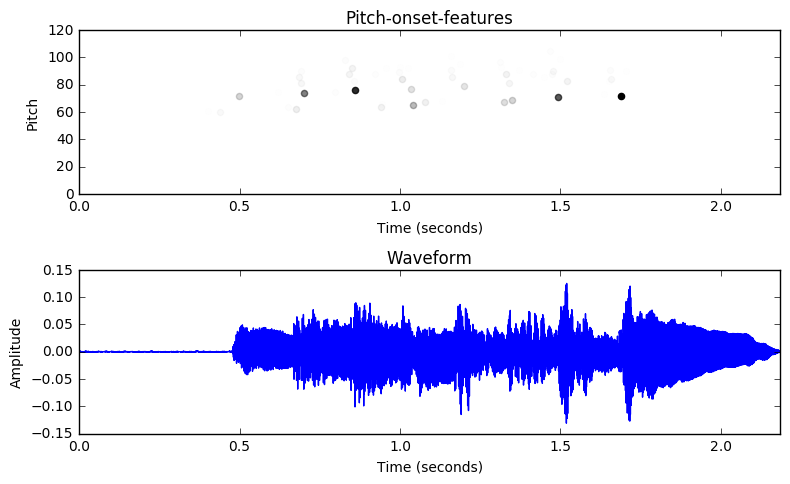

In [7]:
plt.figure(figsize=(8,8/1.61803398875))
plt.subplot(2,1,1)
time = y.size/fs

max_onset = np.max(np.concatenate([onset for time, onset in f_peaks.values()]))

for key in f_peaks.keys():
    for i in range(f_peaks[key][0].size):
        plt.scatter(f_peaks[key][0][i]/1000, key, c='k', alpha=f_peaks[key][1][i]/max_onset)
plt.xlim([0, time])
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch')
plt.title('Pitch-onset-features')
        
plt.subplot(2,1,2)
t = np.arange(0, y.size)/fs
plt.plot(t, y)
plt.xlim([0, time])
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Waveform')

plt.tight_layout()
